<a href="https://colab.research.google.com/github/Dushxn/Deep-Learning-Project/blob/Yasasi-Dev/Dl_PlantVillage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, pathlib, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# **Importing Plantvillage Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your zip file in Drive
zip_path = "/content/drive/MyDrive/plantvillage.zip"

# Unzip into /content (fastest for Colab)
!unzip -q "$zip_path" -d /content/

# Check extracted folder name (sometimes it's "PlantVillage" or similar)
!ls /content


Mounted at /content/drive
 drive	'plantvillage dataset'	 sample_data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os, pathlib

DATA_DIR = "/content/plantvillage dataset/color"   # change if the extracted folder name differs
assert os.path.exists(DATA_DIR), "Check folder name after unzip!"
print("Dataset root:", DATA_DIR)

Dataset root: /content/plantvillage dataset/color


## **Dataset Analysis**

inspect folder structure and counts

In [5]:
root = pathlib.Path(DATA_DIR)
# If dataset has 'train'/'test' folders or 'plant_village' etc, adapt this snippet.
# We'll assume images are organized in subfolders per class:
classes = [p.name for p in root.iterdir() if p.is_dir()]
classes = sorted(classes)
print(f"Found {len(classes)} classes.")
for c in classes[:30]:
    cnt = len(list(root.joinpath(c).glob('*')))
    print(f"{c}: {cnt} images")


Found 38 classes.
Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mil

visualize class distribution (bar plot)

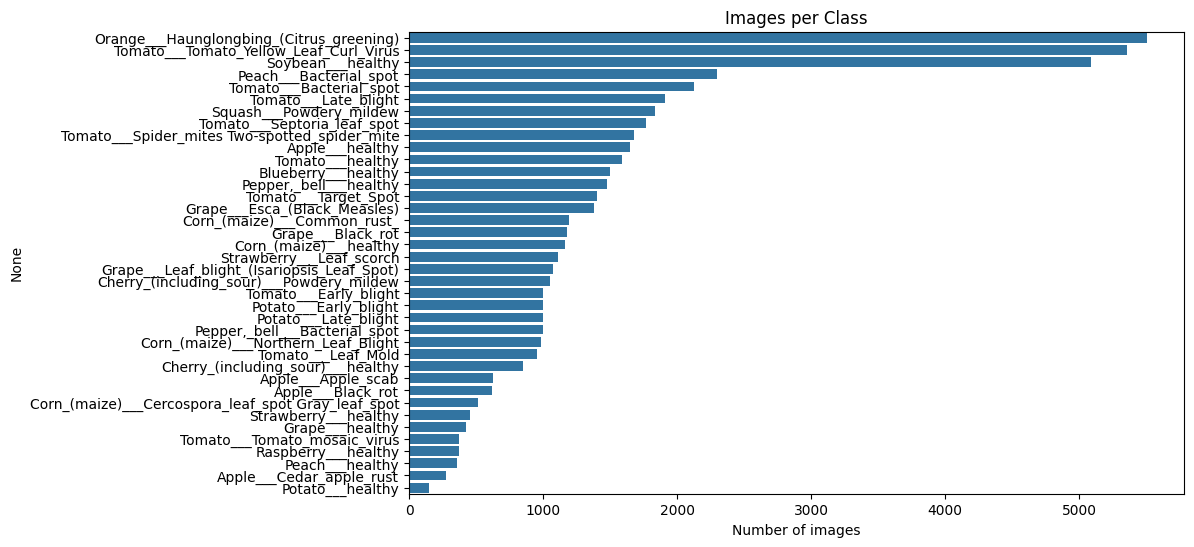

In [6]:
counts = {}
for c in classes:
    counts[c] = len(list(root.joinpath(c).glob('*')))
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=counts_df['count'].values, y=counts_df.index)
plt.title("Images per Class")
plt.xlabel("Number of images")
plt.show()


show sample images per class

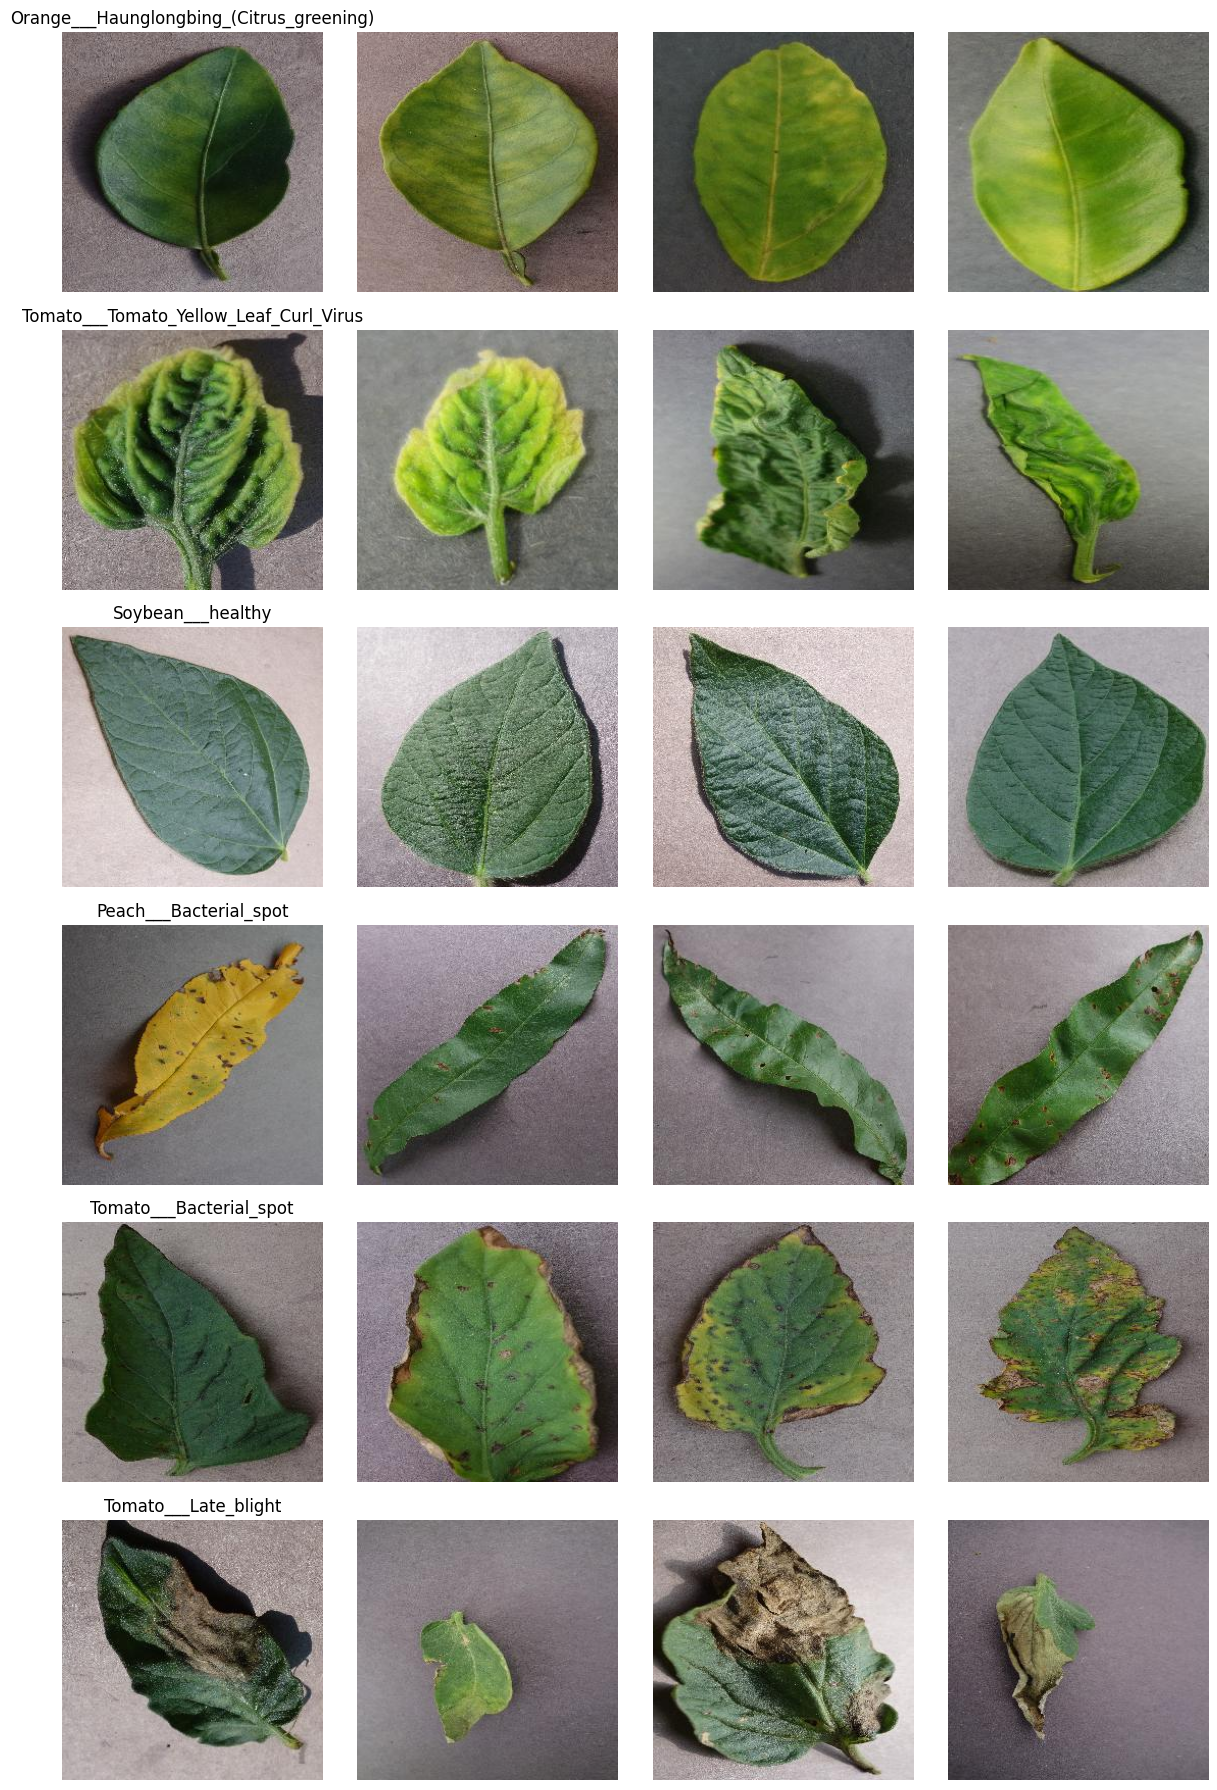

In [7]:
import matplotlib.image as mpimg
def show_samples(classes, n_per_class=3, img_size=(224,224)):
    plt.figure(figsize=(n_per_class*3, len(classes)*3))
    i = 1
    for row, c in enumerate(classes):
        # Filter out directories and only include files
        imgs = [p for p in root.joinpath(c).glob('*') if p.is_file()][:n_per_class]
        for col, img_path in enumerate(imgs):
            ax = plt.subplot(len(classes), n_per_class, i)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            ax.set_title(c if col==0 else "")
            ax.axis('off')
            i += 1
    plt.tight_layout()
# show top 6 classes to avoid huge plot
show_samples(list(counts_df.index[:6]), n_per_class=4)

## **Data Preprocessing**

In [8]:
# Define key parameters
IMG_SIZE = (124, 124) # A standard size for many CNNs
BATCH_SIZE = 16

# Create the training dataset (80% of the data)
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123, # Seed for reproducibility
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Create the validation dataset (20% of the data)
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

# Get the class names (they are inferred in alphabetical order by the function)
class_names = train_ds.class_names
print("Class names:", class_names)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Toma

Configuring for Performance

In [9]:
# This version streams from disk and uses much less RAM
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [10]:
# Create a data augmentation layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

Train Models Below

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




Deep CNN Model

In [12]:
# Number of classes from dataset
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,   # augmentation for training
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),

    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    # Block 4
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),   # avoid overfitting
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compile Model

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # small LR for stable learning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Add Callbacks

In [14]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_deepcnn.keras", save_best_only=True)
]


Train Model

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,       # you can tune this
    callbacks=callbacks
)


Epoch 1/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 206s 63ms/step - accuracy: 0.4843 - loss: 2.0502 - val_accuracy: 0.6579 - val_loss: 1.1636
Epoch 2/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 179s 62ms/step - accuracy: 0.7292 - loss: 0.9386 - val_accuracy: 0.7580 - val_loss: 0.8792
Epoch 3/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 180s 63ms/step - accuracy: 0.8060 - loss: 0.6548 - val_accuracy: 0.7609 - val_loss: 0.8788
Epoch 4/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 179s 63ms/step - accuracy: 0.8561 - loss: 0.4866 - val_accuracy: 0.7747 - val_loss: 0.8747
Epoch 5/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 190s 67ms/step - accuracy: 0.8736 - loss: 0.4180 - val_accuracy: 0.8807 - val_loss: 0.4066
Epoch 6/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 188s 66ms/step - accuracy: 0.8994 - loss: 0.3348 - val_accuracy: 0.7854 - val_loss: 0.8350
Epoch 7/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 178s 63ms/step - accuracy: 0.9084 - loss: 0.2979 - val_accuracy: 0.7520 - val_loss: 1.4397
Epoch 8/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 179s 63ms/step - accuracy: 

Evaluate Model

In [16]:
loss, acc = model.evaluate(val_ds)
print(f" Validation Accuracy: {acc*100:.2f}%")


679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8777 - loss: 0.4126
 Validation Accuracy: 88.07%


Plot Training Curves

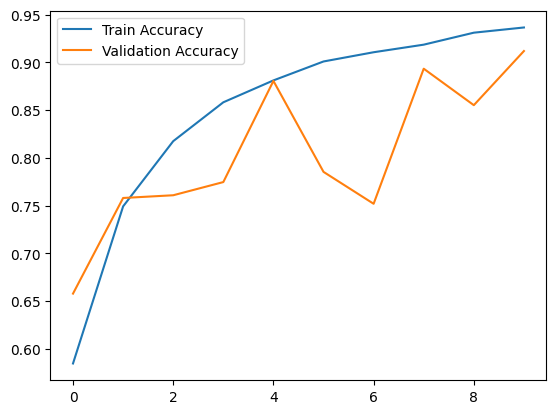

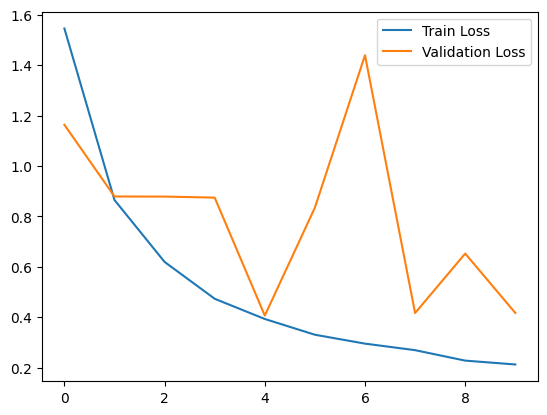

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Test on New Images